In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep, matplotlib.pyplot as plt
from models import ConvNet
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfProjectedGradientDescentAttack
from foolbox.attacks.base import Repeated
from tqdm.notebook import tqdm
from attack_helper import run_batched_attack_cpu, batched_accuracy, batched_predictions, batched_predictions_eps, save_pickle, batched_logits_eps
from mlflow.tracking.artifact_utils import get_artifact_uri

In [2]:
run_name = 1697206030
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = ConvNet(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])


test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])

if df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0] is None:
    flat = False
else:
    flat = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0])

if flat:
    padded_img_size = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.padded_img_size'].values[0])

    if test_rot:
        TEST_PATH = "flat_mnist_test_aug_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"
    else:
        TEST_PATH = "flat_mnist_test_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"

    test_data = load_train_data(TEST_PATH)

else:    
    if test_rot:
        TEST_PATH = "s2_mnist_cs1.gz"
        test_data = load_test_data(TEST_PATH)
    else:
        TEST_PATH = "s2_mnist_test_sphere_center.gz"
        test_data = load_train_data(TEST_PATH)

In [3]:
total = 200
bs = 100

images = test_data[:total][0]
labels = test_data[:total][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

In [4]:
clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# epsilons = [0, 0.1, 0.25, 0.5, 1, 3, 5, 7.5, 10]
epsilons = [0, 0.5, 2.5, 5, 7.5, 10, 14, 20, 30]
rel_stepsize = 0.01/0.3
steps = 70
random_start=True
n_repeat = 3

attack = Repeated(attack=LinfProjectedGradientDescentAttack(rel_stepsize=rel_stepsize, steps=steps, random_start=random_start), times=n_repeat)

In [6]:
_, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons, bs)
advs = torch.stack(advs)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
adv_pred = batched_predictions_eps(model, advs, bs)
logits = batched_logits_eps(model, advs, bs)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
print(success_rate)

tensor([0.0000, 0.0000, 0.0400, 0.0850, 0.1750, 0.3450, 0.6900, 0.9650, 0.9950])


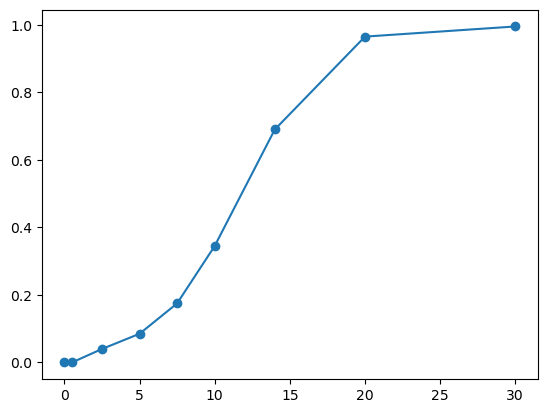

In [9]:
plt.plot(epsilons, success_rate, 'o-')
plt.show()

In [10]:
# imgs = advs[:,labels == 0][:,:10]
# for i in range(1,10):
#     imgs = torch.cat((imgs, advs[:,labels == i][:,:10]), 1)
    
# preds = adv_pred[:,labels == 0][:,:10]
# for i in range(1,10):
#     preds = torch.cat((preds, adv_pred[:,labels == i][:,:10]), 1)
    
# c_preds = clean_pred[labels == 0][:10]
# for i in range(1,10):
#     c_preds = torch.cat((c_preds, clean_pred[labels == i][:10]))
    
# labs = labels[labels == 0][:10]
# for i in range(1,10):
#     labs = torch.cat((labs, labels[labels == i][:10]))

In [11]:
# save_path = os.path.join(artifact_path, attack.attack.__class__.__name__)

# if not os.path.isdir(save_path):
#     os.mkdir(save_path)

In [12]:
# save_pickle(save_path, 'images.pickle', [imgs, preds, c_preds, labs])
# save_pickle(save_path, 'success.pickle', success)
# save_pickle(save_path, 'success_rate.pickle', success_rate)
# save_pickle(save_path, 'post_pred.pickle', adv_pred)
# save_pickle(save_path, 'params.pickle', {'epsilons': epsilons, 'rel_stepsize': rel_stepsize, 'steps': steps, 'random_start': random_start, 'n_repeat': n_repeat})
# save_pickle(save_path, 'logits.pickle', logits)